In [1]:
import torch
import matplotlib.pyplot as plt
from  sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from data import DepictionDataset
import yaml
from  torch.utils.data import DataLoader, random_split
from tqdm.autonotebook import tqdm
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import os
import pandas as pd

/var/folders/6_/9lx62qsd5tg0mmk5dvw14pyw0000gn/T/ipykernel_3945/2510472487.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
with open("config.yml", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)


whole_data = DepictionDataset(annotations_file=cfg["LABEL_FILE_PATH"],
                               img_dir=cfg["IMAGE_DIR_PATH"], 
                               img_size=(224, 224))

eval_data, _ = random_split(dataset=whole_data,
                                    lengths=[int(len(whole_data)*0.7), int(len(whole_data)*0.3)+1],
                                    generator=torch.Generator().manual_seed(32))
eval_dataloader = DataLoader(eval_data, batch_size=60, shuffle=True)

In [3]:
### Set the Device for training ###
if cfg["MACHINE"] == "NPU":
    import torch_directml
    device = torch_directml.device(torch_directml.default_device())
    print("[INFO] ``device`` was set to NPU")

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("[INFO] ``device`` was set to MPS")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("[INFO] ``device`` was set to CUDA")

[INFO] ``device`` was set to MPS


In [4]:
SUMMARY_NAME = 'BEST_VGG19_pre_clean_2023-08-07_15-14-44.pth'
model_path = "models/BEST_VGG19_pre_clean_2023-08-07_15-14-44.pth"
model = torch.load(model_path)
model.eval()
model = model.to(device)
y_true = []
y_pred = []
for image, label in tqdm(eval_dataloader):
    image = image
    label = label
    image, label = image.to(device), label.to(device)
    output = model(image)
    #_, pred = torch.max(output, 1)
    y_true.extend(label.tolist())
    y_pred.extend(output.tolist())
    


  0%|          | 0/84 [00:00<?, ?it/s]

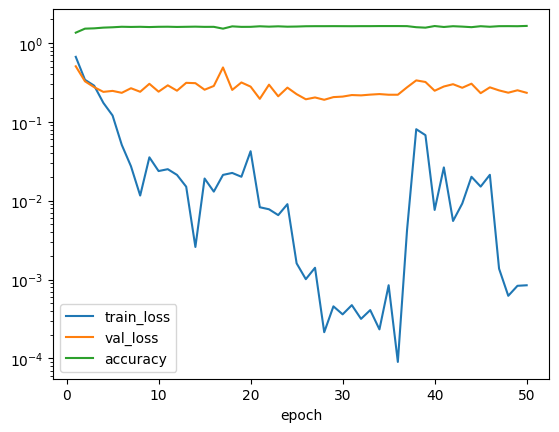

In [5]:
log_path = os.path.join("logs", "LOG" + SUMMARY_NAME[4:-4] + ".txt")
with open(log_path, "r") as f:
    lines = f.readlines()
    lines = [line.strip() for line in lines]
    lines = [lines[i] for i in range(len(lines)) if not lines[i].startswith("#")]
    lines = [lines[i] for i in range(len(lines)) if not lines[i].startswith("EOF")]

# make pandas dataframe from lines and set first row as column names
df = pd.DataFrame([sub.split(",") for sub in lines])
df = df.rename(columns=df.iloc[0]).drop(df.index[0])
# make the data numeric
df = df.apply(pd.to_numeric)
df.plot(x="epoch")
plt.yscale("log")

In [6]:
y_pred = [i.index(max(i)) for i in y_pred]

In [7]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       641
           1       0.97      0.97      0.97       620
           2       0.96      0.97      0.97       610
           3       0.97      0.96      0.97       619
           4       0.98      0.96      0.97       606
           5       0.96      0.96      0.96       620
           6       0.95      0.97      0.96       648
           7       0.95      0.99      0.97       619

    accuracy                           0.97      4983
   macro avg       0.97      0.97      0.97      4983
weighted avg       0.97      0.97      0.97      4983



In [8]:
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

[[607   1   6   0   4   7  16   0]
 [  0 604   0   1   0   6   0   9]
 [  0   0 594   1   7   1   7   0]
 [  0   2   0 597   0   8   1  11]
 [  4   2   7   2 583   0   8   0]
 [  0   7   1   7   0 598   0   7]
 [  5   0  11   1   2   1 626   2]
 [  0   4   0   5   0   0   0 610]]


Text(0.5, 0, 'Predicted')

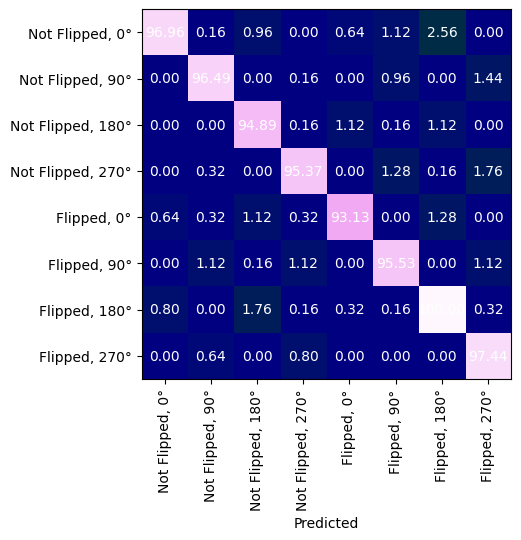

In [17]:
plt.imshow(conf_matrix/conf_matrix.max(), cmap="gist_ncar")
# change the xticks to be the class names, not the indices
plt.xticks(range(8), list(DepictionDataset.labels_map.values()), rotation=90)
plt.yticks(range(8), list(DepictionDataset.labels_map.values()));
# add the confusion scores to the plot
for i in range(8):
    for j in range(8):
        plt.text(j, i, f'{conf_matrix[i, j]/conf_matrix.max()*100:.2f}', ha="center", va="center", color="white")
plt.xlabel("Predicted")